In [1]:
# Load to the data
import pandas as pd
df_tweets = pd.read_csv('data/tweets_data_lda.csv')
df_tweets.head()

,date,like_count,reply_count,retweet_count,text
0,2011-12-01,267,63,24,{I made the volume on the Model S http://t.co...
1,2011-12-03,82,38,31,"{That was a total non sequitur btw, Great Volt..."
2,2011-12-04,65,17,9,{Am reading a great biography of Ben Franklin ...
3,2011-12-21,1330,87,597,{Yum! Even better than deep fried butter: htt...
4,2011-12-22,1349,132,206,{Model S options are out! Performance in red a...


## Data Pre-processing
**Preprocess the data by making it all lowercase. Remove a reasonable set of stopwords from the dataset and tokenize. Then, report the 10 most common words and their count. We need to iterate this process, adding some stop words as we understand the structure of the data. Justify additional stop words we've added.**

In [2]:
# Data Pre-processing and make the tweets all lowercase and remove stopwords.
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')
import math
import math

twitter_df = df_tweets.copy()

# lower the tweets
twitter_df['preprocessed_text'] = twitter_df['text'].str.lower()

# remove apostrophe from words and url
twitter_df['preprocessed_text'] = [re.sub("('[a-z]+)\s", " ", row) for row in twitter_df['preprocessed_text']]
twitter_df['preprocessed_text'] = [re.sub("(')\s", " ", row) for row in twitter_df['preprocessed_text']]
twitter_df['preprocessed_text'] = [re.sub("(?:https:\/\/\S+)\s", "", row) for row in twitter_df['preprocessed_text']]

                                      
# filter out rest URLs
url_re = '(?:https?:\/\/)?(?:[^?\/\s]+[?\/])(.*)'
twitter_df['preprocessed_text'] = twitter_df['preprocessed_text'].apply(lambda row: ' '.join([word for word in row.split() if (not re.match(url_re, word))]))

# tokenize the tweets
tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
twitter_df['tokenized_text'] = twitter_df['preprocessed_text'].apply(lambda row: tokenizer.tokenize(row))

#create an object of class PorterStemmer
porter = PorterStemmer()

# apply stemming
twitter_df['preprocessed_text'] = [porter.stem(row) for row in twitter_df['preprocessed_text']]   

# filter out stop words
en_stop_words = nltk.corpus.stopwords.words('english')
additional_stop_words =['amp', 'rt', 'th','co', 're', 've', 'kim', 'daca', 'us', 'it', 'th', 'you', 'haha', 'st', 'et', 'so', 'iii', 'also', 've', 'la', 're', 'the', 'https', 'wow', 'actually', 'due', 'ft', 'pcr', 'via', 'am', 'gt', 'com', 'since', 'in', 'me', 'and', 'btw', 'yesterday', 'ii', 'inu', 'on', 'http', 'to', 'vs', 'rd', 'ur', 'of', 'bs', 'km', 'est', 'em', 'lz', 'kms', 'aft', 'nd',  'here’s', 're', 'mqxfakpzf' 'mph', 'ht', 'etc', 'dm', 'doo']
en_stop_words.extend(additional_stop_words)

twitter_df['tokenized_text'] = twitter_df['tokenized_text'].apply(lambda row: [word for word in row if (not word in en_stop_words)])

df_tweets_clean = twitter_df.copy()
df_tweets_clean.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zkirsan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,date,like_count,reply_count,retweet_count,text,preprocessed_text,tokenized_text
0,2011-12-01,267,63,24,{I made the volume on the Model S http://t.co...,{i made the volume on the model s go to 11. no...,"[made, volume, model, go, need, work, miniatur..."
1,2011-12-03,82,38,31,"{That was a total non sequitur btw, Great Volt...","{that was a total non sequitur btw, great volt...","[total, non, sequitur, great, voltaire, quote,..."
2,2011-12-04,65,17,9,{Am reading a great biography of Ben Franklin ...,{am reading a great biography of ben franklin ...,"[reading, great, biography, ben, franklin, isa..."
3,2011-12-21,1330,87,597,{Yum! Even better than deep fried butter: htt...,{yum! even better than deep fried butter: yeah...,"[yum, even, better, deep, fried, butter, yeah,..."
4,2011-12-22,1349,132,206,{Model S options are out! Performance in red a...,{model s options are out! performance in red a...,"[model, options, performance, red, black, deli..."


### Bag of Words
If we want to classify text on a topic basis, we often do not want to look at the sequences of words. We do not want to classify text. Instead, we present the text as an unordered word package, ignoring its original position in the text and keeping its frequency.

In [3]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
  
get_most_freq_words([ word for tweet in df_tweets_clean.tokenized_text for word in tweet],10)

[('tesla', 608),
 ('model', 258),
 ('spacex', 213),
 ('good', 177),
 ('rocket', 165),
 ('launch', 159),
 ('car', 155),
 ('falcon', 151),
 ('like', 148),
 ('time', 124)]

### Identify the number of subjects

1 -2.4728835418481574
2 -2.5958546016742443
3 -2.550094582452756
4 -3.3067935795222634
5 -2.9436846719230934
6 -3.179694300591463
7 -3.152384548360034
8 -2.8186684659742496
9 -3.4106758525406122
10 -3.660491766007516
11 -3.7796179987944543
12 -3.846619553473072
13 -3.843095773969232
14 -3.6257902132027


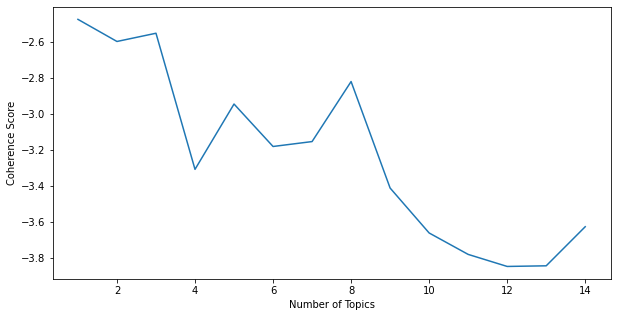

In [8]:
# build a dictionary where for each tweet, each word has its own id.
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

# compute coherence
tweets_coherence = []
for nb_topics in range(1,15):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, alpha= 'auto', eta='auto', id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)
    print(nb_topics,coh)

# visualize coherence
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(1, 15),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

### Running the LDA

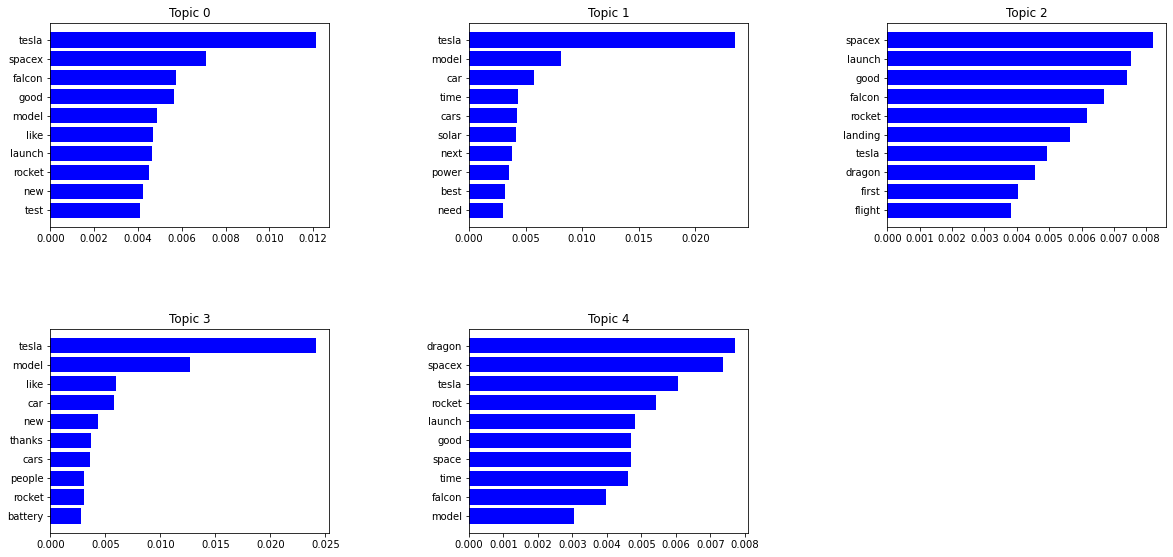

In [9]:
import matplotlib.gridspec as gridspec

k = 5
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
  
plot_top_words()

The topics do not make totally sense. However we can see the following meaningful match:

Topic 1 - tesla

Topic 2, - spaceX

etc

Reference; https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835, date; 2021-07-21, time; 2.25 pm